## To-do
* Add images from paper
    

## Graph Convolutional Network (GCN)

### Summary
* 'Semi-Supervised Classification with Graph Convolutional Networks', T. Kipf & M. Welling, ICLR 2017, https://arxiv.org/abs/1609.02907
* DGL tutorial: https://docs.dgl.ai/en/0.4.x/tutorials/models/1_gnn/1_gcn.html
* Learned hidden representations at each node encode:
    1. Local graph structure
    2. Node features
* Scales linearly with number of graph edges
* Was big step forward in spatial GNN (as opposed to spectral) becoming superior method for ML over large graphs

### Overview
* Uses the *convolution* operation to *aggregate*/*reduce* messages given to each node in graph after message passing
* In most GNNs, each GNN layer (where can stack multiple GNN layers to produce final output) performs 3 stages:
    1. Message function: Defined on each edge in the input graph. Generates a message (some representation) to pass from a source node to some set of destination nodes. Each node stores the messages it receives in its mailbox (memory).
    2. Reduce/aggregate function: Defined on each node in the input graph. Accesses the node's mailbox of messages and applies some function (e.g. mean, max, min, sum, single-layer NN, multi-layer NN, LSTM, etc.) to reduce the messages into an intermediate *aggregate representation*.
    3. NN layer forward pass: Pass the intermediate aggregate representation through a NN model (e.g. a single linear layer) (+ a non-linear/activation function if desired) to produce a final *embedded representation* for each node of the input graph (representing the (1) node features and (2) local graph structure of the original input graph).
    
    
* A discrete convolution operation can be defined as:

$$ s(t) = \frac{1}{m} \sum_{i=1}^{m} x_{i}(a) \cdot w_{i} (t-a) $$

$s(t)$: Feature map (output of convolution)

$x(a)$: Input data (input graph's node features; the input to the NN layer)

$w(a)$: Kernel (muti-dimensional array of tuneable parameters/weights of the NN layer)

* To implement convolution, GCN defined the following to occur in each GCN layer:
    1. Message function: Send (current) hidden representation of each source node's features to destination nodes
    2. Reduce/aggregate function: At each destination node, sum all received messages (hidden node representations of surrounding nodes) to get single intermediate aggregate representation at each node
    3. NN layer forward pass: Collect the aggregated representations at each node into a vector and pass the vector as inputs through a linear NN layer followed by a relu non-linear activation function
* The above is summarised by the formula:

$$ H^{l+1} = \sigma (\tilde{D}^{\frac{1}{2}} \tilde(A) \tilde(D)^{-\frac{1}{2}} H^{l} W^{l}) $$

$l$: GNN layer

$H$: Hidden node representations of current GNN layer

$D$: Input graph degree matrix

$A$: Input graph adjacency matrix

$\tilde{}$: Denotes a 'renormalisation trick' where add a self-connection to each node of the graph and build the corresponding degree and adjacency matrix

$W$: Weight matrix of the NN layer in current GNN layer

$\sigma$: Non-linearity (relu was used)
    
* In the first GCN layer, the input $H^{0}$ is an $N \times D$ tensor, where $N$ is the number of nodes in the input graph and $D$ is the number of features on each node. Can stack multiple GNN layers, with the final node-level representation output by the last GNN layer being an $N \times F$ tensor, where $F$ is the number of possible classes. Can then pass representation through e.g. a softmax layer to classify each node into one of the $F$ possible classes. N.B. If wanted to do graph-level representation, would instead pass final GNN layer output through a *readout function* (usually another trainable NN layer) which takes node-level representations and outputs a graph-level logit representation with number of dimensions equal to the number of possible graph classes, which itself can then be passed through e.g. a softmax function to classify the whole graph.

*Insert Figure 1*

### Paper Implementation Details
* Tackled a **semi-supervised learning** problem where only some of the input data have labels. Used **citation datasets** (**Cora, Citesser, Pubmed**) where each dataset was given a **label rate** (fraction defining fraction of labeled nodes that were used for training (e.g. was 0.052 for Cora, meaning 5% of labeled nodes were used for training, therefore 'semi-supervised'))

*Insert Table 1*

* Used **categorical cross-entropy loss function**
* Used **2 GCN layers**, so had 2 NN layers in total (with weights $W^{0}$ and $W^{1}$ respectively) which were optimised using **full-batch gradient descent** (viable so long as the dataset fits in memory) (from paper: 'We leave memory-efficient extensions with mini-batch stochastic gradient descent for future work')
* Stochasticity/regularisation in training process introduced via **dropout_rate = 0.5** and **L2_regularisation_parameter = $5 \times 10^{-4}$** for *all* GCN layers
* Used **Adam optimiser** (**learning rate = 0.01**) trained with a maximum **num_epochs = 200**, where training was stopped with **window_size = 10** (i.e. stop training if validation loss does not decrease for 10 consecutive epochs)
* NN in each GNN layer had **16 hidden units**
* All test accuracies reported were the mean accuracies from **100 runs**

*Insert Table 2*

* For large graphs (1 million < num_edges <= 10 million), GPU ran out of memory, but CPU could still handle and train in reasonable times. This paper was before GraphSage, which was first paper to implement mini-batching and neighbourhood sampling for GNNs thereby by-passing this memory/scalability issue

*Insert Figure 2*

* Tested using 1-10 GCN layers. Found that if didn't add **residual connections**, can have GCN model up to **2 layers deep** before test accuracy drops off dramatically (since context size for each node increase by the size of its Kth order neighborhood for a GNN model with K layers), and that even with residual connections, test accuracy stays relatively constant, so no point adding more than 2 GNN layers and therefore no need for residual connections. Suggested reason for this is due to *overfitting* issues as the number of parameters increases with model depth.

*Insert Figure 5*
    


## TensorFlow and DGL Implementation of GCN

### Define GCN Model

In [1]:
import dgl
import tensorflow as tf

Using backend: tensorflow


* Define a simple fully-connected NN layer: 

In [2]:
from tensorflow.keras.layers import Layer

class Linear(Layer):
    '''Fully-connected (FC) linear layer.'''
    
    def __init__(self, units, bias=True, activation=None):
        super(Linear, self).__init__()
        
        self.units = units # num units in layer == num dimensions to output (therefore final layer needs units == num_classes)
        self.bias = bias # whether or not to bias units in layer
        self.activation = activation # (optional) activation function/non-linearity to pass output of linear operation
        
    def build(self, input_shape):
        '''Initialises layer weights & biases according to shape of input.'''
        # weights
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(initial_value=w_init(shape=(input_shape[-1], self.units), dtype='float32'), 
                             trainable=True)
        
        # biases
        if self.bias:
            b_init = tf.zeros_initializer()
            self.b = tf.Variable(initial_value=b_init(shape=(self.units,), dtype='float32'),
                                 trainable=True)
        else:
            self.b = None

    def call(self, inputs):
        '''Performs forward propagation through layer when layer called.
        
        When called for the first time, will automatically run self.build().
        
        '''
        # linear operation
        if self.b is not None:
            h = tf.matmul(inputs, self.w) + self.b
        else:
            h = tf.matmul(inputs, self.w)
            
        # activation function/non-linearity
        if self.activation is None:
            pass
        elif self.activation == 'relu':
            h = tf.nn.relu(features=h)
        elif self.activation == 'leaky_relu':
            h = tf.nn.leaky_relu(features=h)
        else:
            raise Exception('Invalid \'activation\' argument: {}.'.format(activation))
        
        return h

* Recall that a GCN layer performs the following stages:
    1. Message function: Send (current) hidden representation of each source node's features to destination nodes
    2. Reduce/aggregate function: At each destination node, sum all received messages (hidden node representations of surrounding nodes) to get single intermediate aggregate representation at each node
    3. NN layer forward pass: Collect the aggregated representations at each node into a vector and pass the vector as inputs through a linear NN layer followed by a relu non-linear activation function
* Define a GCN layer:



In [3]:
from tensorflow.keras.models import Model

class GCNLayer(Model):
    def __init__(self, out_feats, activation):
        super(GCNLayer, self).__init__()
                
        # define message & reduce functions as usual
        self.gcn_message_func = dgl.function.copy_src(src='h', out='m') # simply pass (current) hidden node features h from source to mailbox m of destination node(s)
        self.gcn_reduce_func = dgl.function.sum(msg='m', out='h') # sum the received messages at each destination node to generate a new aggregate intermediate hidden representation h for each node
        
        # init fully connected linear layer
        self.linear = Linear(units=out_feats, bias=True, activation=activation)
        
    def call(self, g, features):
        # use local scope so stored ndata and edata (e.g. h ndata) automatically popped out when scope exits
        with g.local_scope():
            # enter node features
            g.ndata['h'] = features
            
            # pass messages between nodes & aggregate messages
            g.update_all(self.gcn_message_func, self.gcn_reduce_func)
            
            # retrieve new intermediate aggregate representation for each node
            h = g.ndata['h']
            
            # forward aggregated messages through FC NN layer to get GNN layer's hidden node representation
            h = self.linear(inputs=h)
            
            return h

* Stack GCN layers to create a GCN model which outputs logits, which can then be passed through a e.g. softmax function to get node predictions/classifications:

In [4]:
class GCN(Model):
    '''Implementation of convolutional graph neural network.
    
    Must configure input, hidden and output layers by using the layers_config
    dict. Specify out_feats for each layer to specify the number of output
    features each layer should output. The model will automatically set the
    number of input features for each layer based on what is being passed into
    the layer when called. N.B. NN must have minimum of 1 layer. N.B.2. The number
    of elements given to out_feats and activations lists should be equal and
    will correspond to the total number of layers (input, hidden and output)
    in the model.
    
    The final layer (the output layer) should have activation==None so that
    the model outputs logits, which may then be externally converted into 
    probability predictions using e.g. softmax.
    N.B. The final value in out_feats arg list should be the number of classes
    being classified by the output layer (e.g. if have 7 classes to classify 
    inputs into, final out_feats val should be 7).
    
    '''
    def __init__(self,
                 layers_config={'out_feats': [16, 7],
                                'activations': ['relu', None]}):
        super(GCN, self).__init__()

        self.model_name = 'graph_conv'

        assert len(layers_config['out_feats']) >= 1, \
                'Must specify out_feats for >=1 layer(s)'
        assert len(layers_config['out_feats']) == len(layers_config['activations']), \
                'Must specify out_feats and activations for all layers \
                (have specified {} out_feats and {} activations)'.format(len(layers_config['out_feats']),
                                                                         len(layers_config['activations']))
        assert layers_config['activations'][-1] is None, \
                'Final layer must have activation as None to output logits'

        # stack GCN layers
        self._layers = []
        n_layers = len(layers_config['out_feats'])
        for i in range(n_layers):
            self._layers.append(GCNLayer(out_feats=layers_config['out_feats'][i],
                                         activation=layers_config['activations'][i]))

        self.num_layers = len(self._layers)

    def call(self, g, features):
        '''Forward graph node features through all GNN layers, generating feature & local structure representations for each node.'''
        
        h = features
        for layer in self._layers:
            h = layer(g, h)

        return h

### Load Dataset

In [5]:
import numpy as np

def unpack_dataset(dataset):
    graph = dataset[0]
    features = graph.ndata['feat']
    labels = graph.ndata['label']
    train_mask = graph.ndata['train_mask']
    val_mask = graph.ndata['val_mask']
    test_mask = graph.ndata['test_mask']

    return graph, features, labels, train_mask, val_mask, test_mask

def load_data(dataset='cora'):
    if dataset == 'cora':
        data = dgl.data.CoraGraphDataset()
    elif dataset == 'citeseer':
        data = dgl.data.CiteseerGraphDataset()
    elif dataset == 'pubmed':
        data = dgl.data.PubmedGraphDataset()
    elif dataset == 'reddit':
        data = dgl.data.RedditDataset()
    else:
        raise ValueError('Unknown dataset: {}'.format(dataset))

    return unpack_dataset(data)

g, features, labels, train_mask, val_mask, test_mask = load_data('cora')

# one-hot encode labels
num_classes = int(len(np.unique(labels)))
onehot_labels = tf.one_hot(indices=labels, depth=num_classes)

Loading from cache failed, re-processing.
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


The Cora dataset is made up of 2,708 scientific publications (modelled as nodes) classified into 1 of 7 possible classes. Where one paper has cited another, an edge has been added between the nodes/papers, producing 10,556 edges in total. Each node has a set of features, where the features are a 0/1 valued word vector indicating the absence/presence of the corresponding word in the paper from a dictionary, and where the dictionary has been defined as 1,433 unique words.

The train, test and validation masks are lists of boolean values for each node, separating the dataset into train, test and validation sets.

About 5% of the 2,708 labeled nodes are used in the training set, making this a so-called 'semi-supervised' task.

In [6]:
print('\nFeatures:\n{}'.format(features))
print(features.numpy().shape)

print('\nLabels:\n{}'.format(labels))
print(labels.numpy().shape)

print('\nTrain Mask:\n{}'.format(train_mask))
print(train_mask.numpy().shape)

print('\nValidation Mask:\n{}'.format(val_mask))
print(val_mask.numpy().shape)

print('\nTest Mask\n{}'.format(test_mask))
print(test_mask.numpy().shape)


Features:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(2708, 1433)

Labels:
[3 4 4 ... 3 3 3]
(2708,)

Train Mask:
[ True  True  True ... False False False]
(2708,)

Validation Mask:
[False False False ... False False False]
(2708,)

Test Mask
[False False False ...  True  True  True]
(2708,)


Visualising the Cora graph:

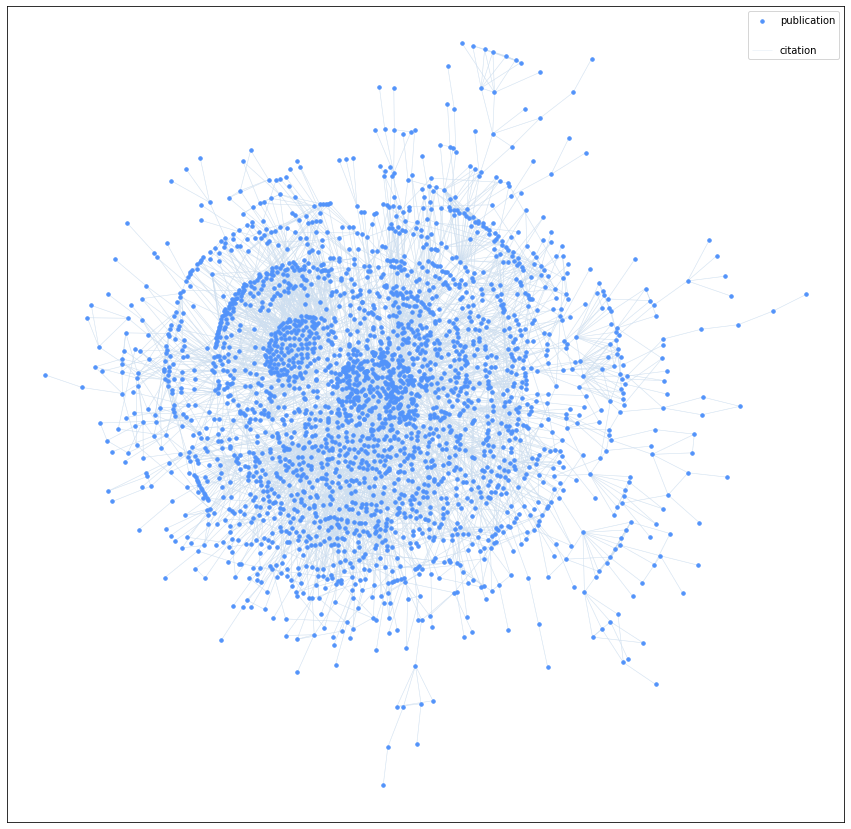

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

networkx_g = g.to_networkx()
pos = nx.kamada_kawai_layout(networkx_g)

fig_scale=1
fig = plt.figure(figsize=[15*fig_scale,15*fig_scale])

# nodes
nx.draw_networkx_nodes(networkx_g,
                       pos,
                       nodelist=networkx_g.nodes(),
                       node_size=12,
                       node_color='#5293fa',
                       label='publication')
# edges
nx.draw_networkx_edges(networkx_g,
                       pos,
                       edgelist=networkx_g.edges(),
                       edge_color='#cedff0',
                       arrows=False,
                       width=0.5,
                       alpha=0.6,
                       label='citation')

plt.legend(labelspacing=2)

plt.show()

### Define Evaluation Function

* Need a function to use to test the model on both the validation and the test data set(s):


In [8]:
def evaluate(model, g, features, labels, mask):
    logits = model(g, features)
    if type(mask[0].numpy()) == np.bool_:
        logits = tf.boolean_mask(tensor=logits, mask=mask)
        labels = tf.boolean_mask(tensor=labels, mask=mask)
    else:
        logits = tf.gather(logits, mask)
        labels = tf.gather(labels, mask)
    indices = tf.math.argmax(logits, axis=1)
    indices = tf.one_hot(indices=indices, depth=len(labels[0]))
    correct = 0
    for i in range(len(labels)):
        if np.array_equal(indices.numpy()[i], labels.numpy()[i]):
            correct+=1
    acc = correct / len(labels)

    return acc

### Train & Test the GNN



In [9]:
with tf.device('/cpu:0'):
    # init gnn model
    layers_config = {'out_feats': [32, num_classes],
                     'activations': ['relu', None]}
    model = GCN(layers_config=layers_config)

    # add edges between each node and itself to preserve old node representations
    g.add_edges(g.nodes(), g.nodes())

    # define optimiser
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

    # run training loop
    all_loss = []
    all_acc = []
    all_epochs = []
    all_logits = []
    num_epochs = 200
    for epoch in range(num_epochs):
        with tf.GradientTape() as tape:
            logits = model(g, features)
            all_logits.append(logits)
            loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.boolean_mask(tensor=onehot_labels, mask=train_mask),
                                                           logits=tf.boolean_mask(tensor=logits, mask=train_mask))
            all_loss.append(tf.keras.backend.mean(loss))
            grads = tape.gradient(loss, model.trainable_variables)
            opt.apply_gradients(zip(grads, model.trainable_variables))
        acc = evaluate(model, g, features, onehot_labels, val_mask)
        all_acc.append(acc)
        all_epochs.append(epoch)
        print('Epoch: {} | Training loss: {} | Validation accuracy: {}'.format(epoch, tf.keras.backend.mean(loss), acc))

    acc = evaluate(model, g, features, onehot_labels, test_mask)
    print('Final test accuracy: {}'.format(acc))

Instructions for updating:
Use tf.identity instead.
Epoch: 0 | Training loss: 1.949454665184021 | Validation accuracy: 0.234
Epoch: 1 | Training loss: 1.947632908821106 | Validation accuracy: 0.234
Epoch: 2 | Training loss: 1.9458199739456177 | Validation accuracy: 0.236
Epoch: 3 | Training loss: 1.9440128803253174 | Validation accuracy: 0.24
Epoch: 4 | Training loss: 1.9421966075897217 | Validation accuracy: 0.242
Epoch: 5 | Training loss: 1.9403833150863647 | Validation accuracy: 0.244
Epoch: 6 | Training loss: 1.9385744333267212 | Validation accuracy: 0.248
Epoch: 7 | Training loss: 1.936849594116211 | Validation accuracy: 0.254
Epoch: 8 | Training loss: 1.9351290464401245 | Validation accuracy: 0.26
Epoch: 9 | Training loss: 1.9334132671356201 | Validation accuracy: 0.268
Epoch: 10 | Training loss: 1.93170166015625 | Validation accuracy: 0.284
Epoch: 11 | Training loss: 1.929992914199829 | Validation accuracy: 0.288
Epoch: 12 | Training loss: 1.9282886981964111 | Validation accurac

Epoch: 106 | Training loss: 1.7119672298431396 | Validation accuracy: 0.63
Epoch: 107 | Training loss: 1.709127426147461 | Validation accuracy: 0.632
Epoch: 108 | Training loss: 1.7062920331954956 | Validation accuracy: 0.636
Epoch: 109 | Training loss: 1.7034562826156616 | Validation accuracy: 0.636
Epoch: 110 | Training loss: 1.7006131410598755 | Validation accuracy: 0.638
Epoch: 111 | Training loss: 1.697763442993164 | Validation accuracy: 0.642
Epoch: 112 | Training loss: 1.6949262619018555 | Validation accuracy: 0.648
Epoch: 113 | Training loss: 1.6920894384384155 | Validation accuracy: 0.648
Epoch: 114 | Training loss: 1.6892443895339966 | Validation accuracy: 0.652
Epoch: 115 | Training loss: 1.6864001750946045 | Validation accuracy: 0.652
Epoch: 116 | Training loss: 1.6835533380508423 | Validation accuracy: 0.652
Epoch: 117 | Training loss: 1.6807050704956055 | Validation accuracy: 0.654
Epoch: 118 | Training loss: 1.6778603792190552 | Validation accuracy: 0.658
Epoch: 119 | Tr

### Visualise

We can first re-plot the Cora dataset, but now colouring the nodes by their ground truth label/category.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

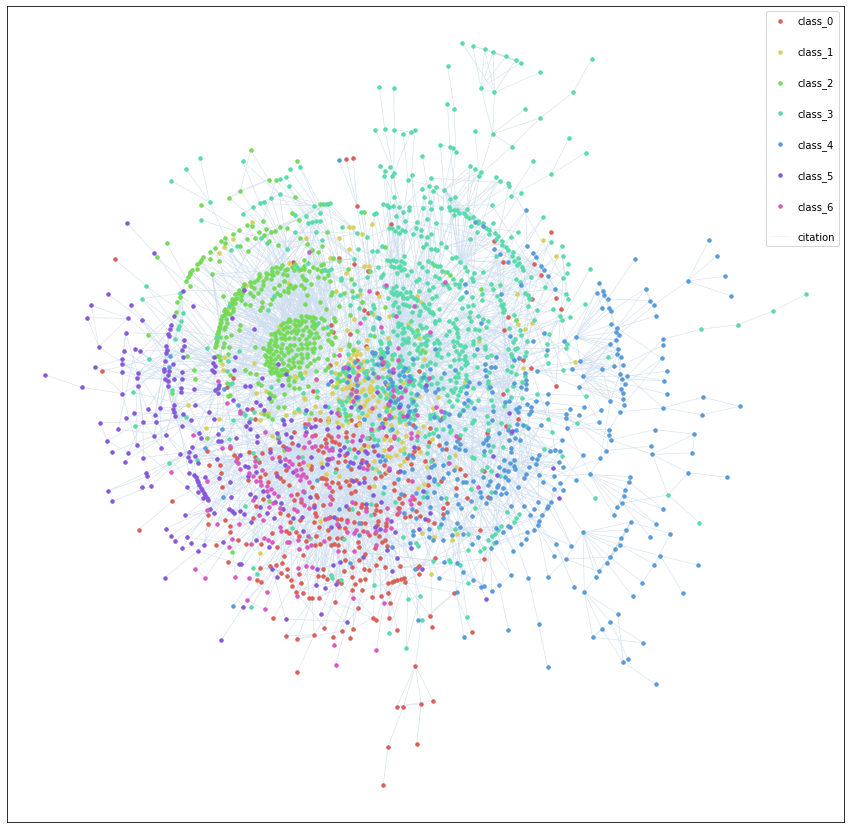

In [10]:
import seaborn as sns

def visualise_classes(net, pos, _labels, num_classes, plot_edges=True, fig_scale=1):
    fig = plt.figure(figsize=[15*fig_scale,15*fig_scale])
    
    # nodes
    category_colours = iter(sns.color_palette(palette='hls', n_colors=num_classes, desat=None))
    colour_dict = {i: next(category_colours) for i in range(num_classes)}
    
    node_ids = net.nodes()
    node_class_dict = {_class: [] for _class in range(num_classes)}
    labs = iter(_labels)
    for node_id in node_ids:
        lab = next(labs)
        node_class_dict[lab].append(node_id)
    
    for _class in node_class_dict.keys():
        nx.draw_networkx_nodes(networkx_g,
                               pos,
                               nodelist=node_class_dict[_class],
                               node_size=12,
                               node_color=colour_dict[_class],
                               label='class_'+str(_class))
    # edges
    if plot_edges:
        nx.draw_networkx_edges(networkx_g,
                               pos,
                               edgelist=networkx_g.edges(),
                               edge_color='#cedff0',
                               arrows=False,
                               width=0.5,
                               alpha=0.6,
                               label='citation')
    
    # legend
    plt.legend(labelspacing=2)
    
    plt.show()
    

visualise_classes(networkx_g, pos, _labels=labels.numpy(), num_classes=num_classes, fig_scale=1)    

The logits (final output of the GNN model) have been saved for each epoch, with the first list of logits being the output of the GNN after 1 epoch and the final list the output after the final epoch.

In [11]:
print(np.array(all_logits).shape)
print(all_logits)

(200, 2708, 7)
[<tf.Tensor: shape=(2708, 7), dtype=float32, numpy=
array([[-2.1596925e-02, -2.5979797e-03, -2.2162920e-02, ...,
        -3.7547901e-02, -5.1727006e-03, -2.3179457e-02],
       [-3.1498806e-03, -1.0060272e-02, -1.3450791e-02, ...,
         1.1377747e-02, -1.7697245e-02,  1.1734664e-02],
       [-4.2785525e-02, -3.6145803e-02, -9.5188588e-02, ...,
         3.3050906e-02, -8.8551708e-02,  3.3960316e-02],
       ...,
       [ 4.0825382e-03, -5.4821114e-05,  1.8598161e-03, ...,
         5.7877004e-03, -3.5420891e-03, -4.9297283e-03],
       [-1.8228889e-02,  7.9520140e-04, -1.0161321e-02, ...,
        -3.0533909e-03, -1.5117084e-02, -2.1987336e-03],
       [-8.3493590e-02,  7.7152099e-03, -2.1021450e-02, ...,
        -2.1475477e-02, -6.7865811e-03, -8.0518844e-03]], dtype=float32)>, <tf.Tensor: shape=(2708, 7), dtype=float32, numpy=
array([[-2.1483866e-02, -2.5093760e-03, -2.1304857e-02, ...,
        -3.7915394e-02, -5.6069200e-03, -2.3856055e-02],
       [-2.8131742e-03, -9

To convert logits into predictions, pass them through e.g. a softmax function to get a probability distribution across all possible classes. For the Cora dataset, there are 7 possible classes, hence why for 2,708 nodes, the shape of the GNN's output logits tensor is 2708 x 7 (and will have 200 of these if collecting across all 200 epochs). The class with the highest probability should be considered that predicted by the GNN, therefore we just find the maximum argument along axis=1 for each row (input node) in the softmax output tensor.

GNN model's node category predictions after first epoch of training:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

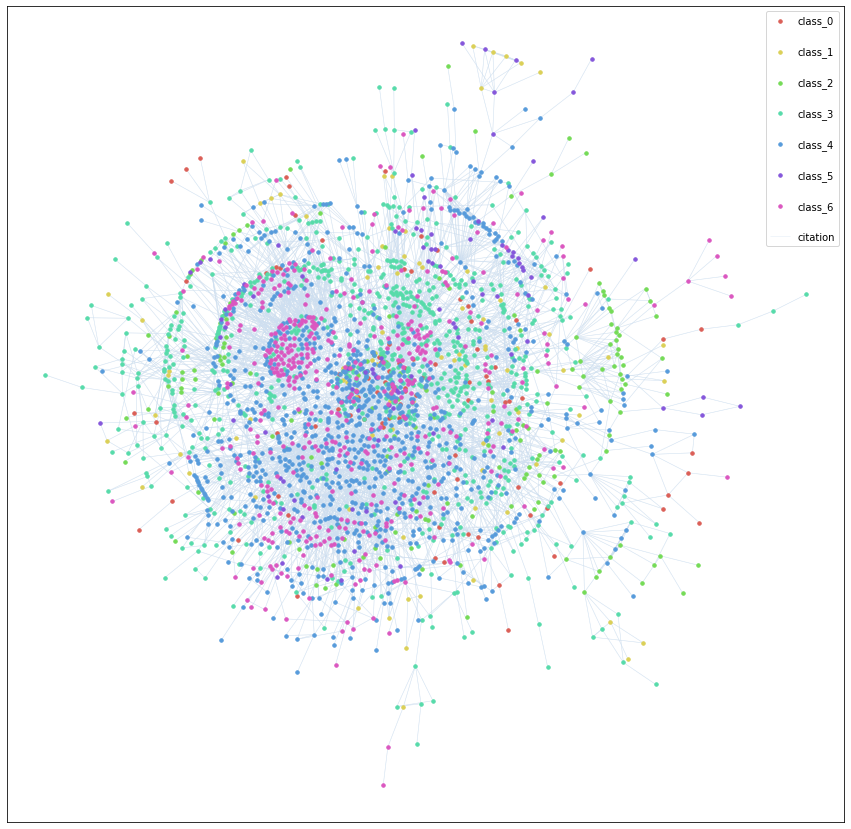

In [12]:
probabilities = tf.nn.softmax(all_logits[0])
predictions = np.argmax(probabilities.numpy(), axis=1)

visualise_classes(networkx_g, pos, _labels=predictions, num_classes=num_classes, fig_scale=fig_scale)

As expected, after just 1 epoch, the GNN model's predictions are quite different from the ground truth node labels.

GNN model's predictions after final epoch of training:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

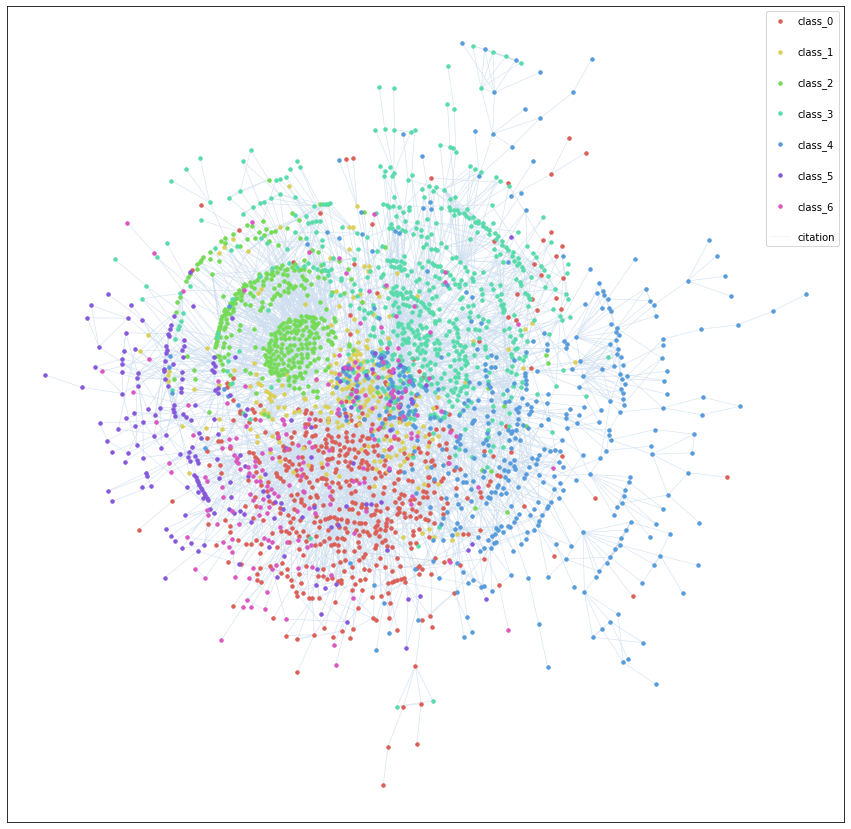

In [13]:
probabilities = tf.nn.softmax(all_logits[-1])
predictions = np.argmax(probabilities.numpy(), axis=1)

visualise_classes(networkx_g, pos, _labels=predictions, num_classes=num_classes, fig_scale=fig_scale)

As expected, after training through all 200 epochs, the GNN's node predictions are much closer to the ground truth labels.

### t-distributed Stochastic Neighbor Embedding (t-SNE) Visualisation

* Method for reducing high-dimensional data down to 2 dimensions for visualisation ('Visualising Data using t-SNE', Journal of Machine Learning Research, 2008, L. van der Maaten & G. Hinton, https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)
* Useful resources:
    * https://distill.pub/2016/misread-tsne/
    * https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
    * https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868
* Can use t-SNE plot to visualise multi-dimensional logit output of ML model (in our case, each node has 7-dimensional representation) by compressing dimensions down to 2 dimensions
* N.B. If have very high-dimensional (>50 dimensions) data/features that want t visualise, should first use another dimensionality-reduction algorithm (e.g. PCA) to reduce to <=50 dimensions before applying t-SNE
* N.B.2. Will likely need to tune t-SNE hyperparameters (perplexity, number of iterations etc.) to get good plots/cluster separation

In [14]:
from sklearn.manifold import TSNE

def visualise_logits(net, _logits, num_classes, perplexity, n_iter, plot_edges=True, fig_scale=1):
    fig = plt.figure(figsize=[15*fig_scale,15*fig_scale])
    category_colours = iter(sns.color_palette(palette='hls', n_colors=num_classes, desat=None))
    colour_dict = {i: next(category_colours) for i in range(num_classes)}
    
    # init tsne obj
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=n_iter)
    
    # compress logits to n_components=2 dimensions
    tsne_embedding = tsne.fit_transform(_logits)
    
    # get gnn predictions
    probabilities = tf.nn.softmax(_logits)
    predictions = np.argmax(probabilities.numpy(), axis=1)
    
    # nodes
    node_ids = networkx_g.nodes()
    node_class_dict = {_class: [] for _class in range(num_classes)}
    gnn_pos = {}
    preds = iter(predictions)
    embds = iter(tsne_embedding)
    for node_id in node_ids:
        gnn_pos[node_id] = next(embds)
        node_class_dict[next(preds)].append(node_id)
    for _class in node_class_dict.keys():
        nx.draw_networkx_nodes(networkx_g,
                               gnn_pos,
                               nodelist=node_class_dict[_class],
                               node_size=12,
                               node_color=colour_dict[_class],
                               label='class_'+str(_class))
    
    # edges
    if plot_edges:
        nx.draw_networkx_edges(networkx_g,
                               gnn_pos,
                               edgelist=networkx_g.edges(),
                               edge_color='#cedff0',
                               arrows=False,
                               width=0.5,
                               alpha=0.6,
                               label='citation')

    # legend
    plt.legend(labelspacing=2)

    plt.show()
    
perplexity = 37
n_iter = 10000

GNN output logits after 1st epoch:

[t-SNE] Computing 112 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.002s...
[t-SNE] Computed neighbors for 2708 samples in 0.107s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 0.013798
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.964035


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

[t-SNE] KL divergence after 4700 iterations: 1.266056


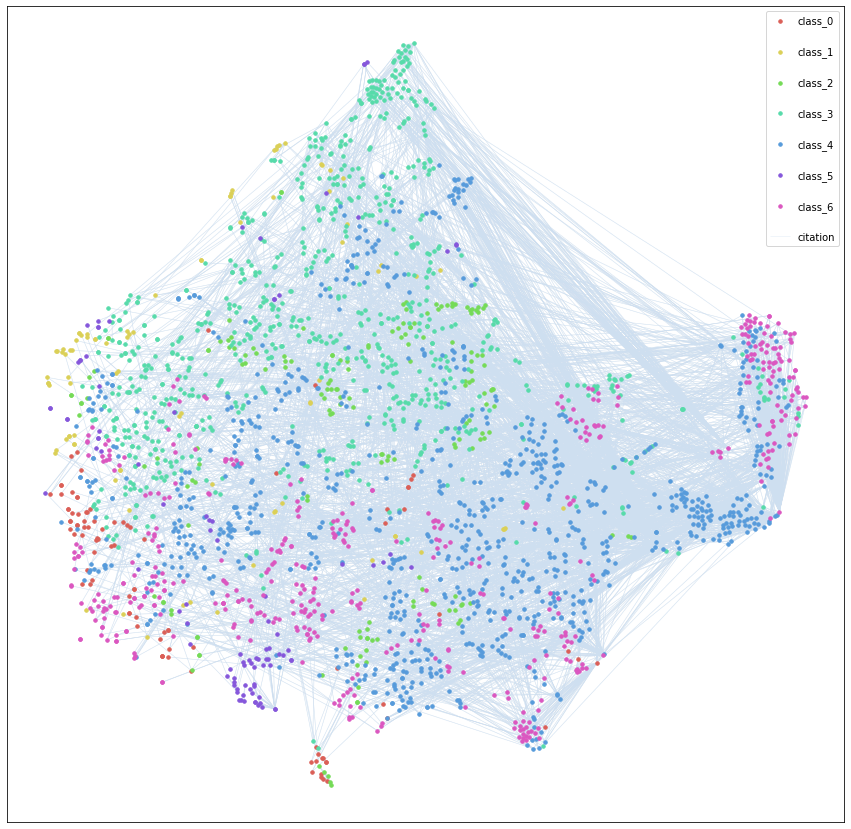

In [15]:
visualise_logits(networkx_g, all_logits[0], num_classes=num_classes, perplexity=perplexity, n_iter=n_iter, plot_edges=True, fig_scale=fig_scale)

GNN output logits after final epoch:

[t-SNE] Computing 112 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.003s...
[t-SNE] Computed neighbors for 2708 samples in 0.119s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 0.057528
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.545982


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

[t-SNE] KL divergence after 5650 iterations: 0.721502


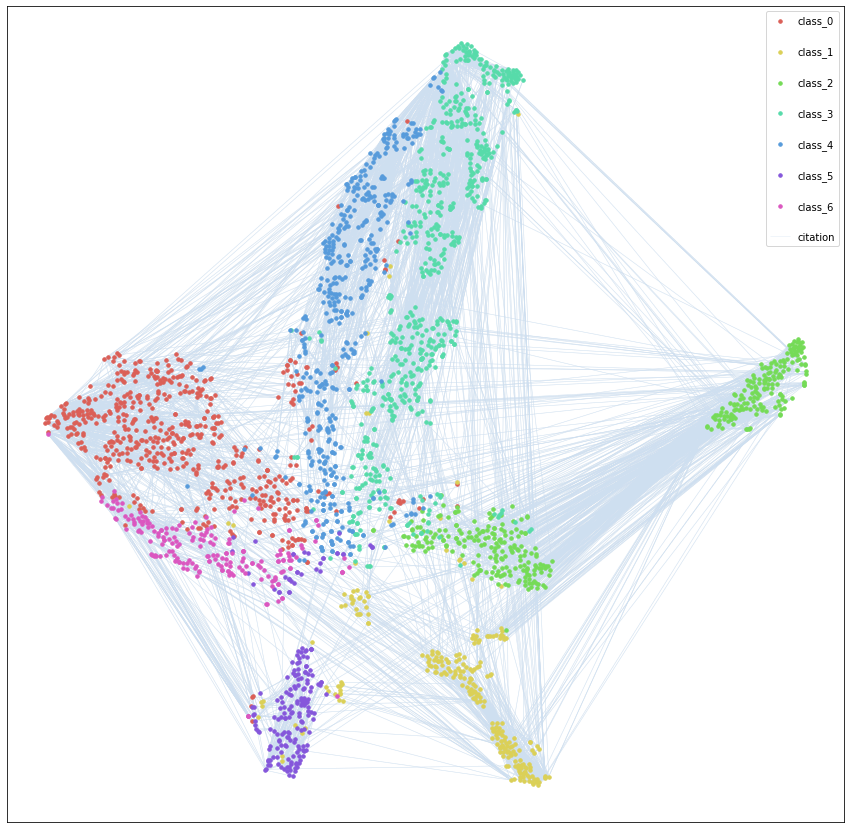

In [16]:
visualise_logits(networkx_g, all_logits[-1], num_classes=num_classes, perplexity=perplexity, n_iter=n_iter, plot_edges=True, fig_scale=fig_scale)

As expected, the GNN learns how to generate output embedding representations of the input graph nodes such that different classes of nodes are separated in its embedded representation space, allowing the GNN to classify the nodes.

N.B. The above plots can likekly be improved by tuning the t-SNE hyperparameters. Better examples of using t-SNE plots to visualise the Cora dataset are shown in https://www.researchgate.net/publication/336316756_Rethinking_Kernel_Methods_for_Node_Representation_Learning_on_Graphs and https://arxiv.org/pdf/1710.10903.pdf